# Build json file from folders
### This pictures helps to understand how the artworks are distributed in the walls of the gallery. It is only needed if you want to dive into the code.

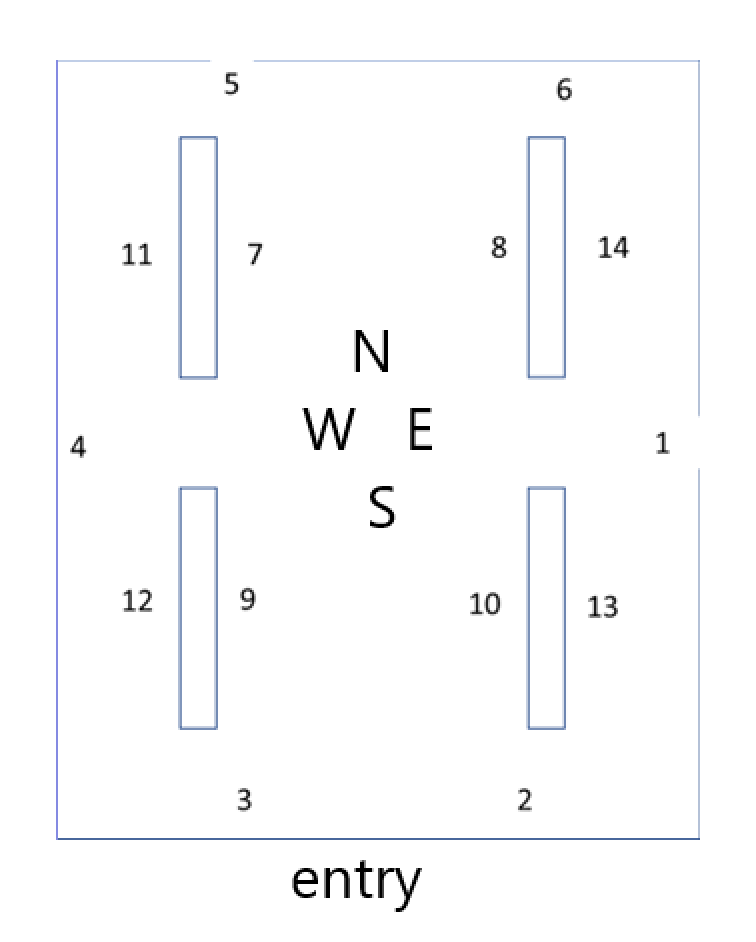

In [1]:
from PIL import Image
import json
import glob
import re
import pandas as pd
import os
import math
import numpy as np

## Constants

In [6]:
csv_file='building_v2.csv'
output_file="../building_v2.json"
image_types=('jpg', 'jpeg', 'png', 'tif')
csv_separator=','
current_directory=os.getcwd() 
galleries_folder=current_directory +"/.."


## Object to assign artworks automatically in a gallery

In [7]:
#code to distribute items
class GalleryWithOptionalPanels:
    def __init__(self, W=30,L=60):


        panel_position_x=W/5
        panel_position_y=L/4
        panel_length=L/4
        panel_thickness=0.5
        item_height=2
        free_space=0.75
        item_max_size=2.5
        min_spacing=3
        door=1
        

        self.geometry={"W": W, "L":L , "item_height": item_height, "panel_position_x": panel_position_x, "panel_length": panel_length, 
                "panel_thickness": panel_thickness,"free_space":free_space, "item_height": item_height, "panel_position_y":panel_position_y,
                "min_spacing":min_spacing, "item_max_size": item_max_size}

        #the saturation self.density is the inverse of the spacing
        self.densitity_saturation=1/self.geometry["min_spacing"]

        long_wall=(L-free_space*2)
        short_wall=(W/2-door/2-free_space*2)
        panel=panel_length-free_space*2

        Lengths1=[long_wall,short_wall,short_wall,long_wall,short_wall,short_wall ]
        Lengths2=[panel, panel, panel, panel, panel, panel, panel, panel]
        self.Lengths=Lengths1 + Lengths2

        if (item_max_size> min_spacing):
            print(f'ERROR: The item size cannot be larger than the spacing')
       
        

    def assign_occupancy(self, N, silent=True):
        #occupancy_max=np.floor(np.array(self.Lengths)/self.geometry["min_spacing"])
        occupancy_max=np.floor( (np.array(self.Lengths)- self.geometry["item_max_size"])/self.geometry["min_spacing"]+1)
        self.occupancy=occupancy_max*0
        self.panels_off=True

        #initialize the panels
        self.occupancy[6:]=occupancy_max[6:]
        self.density=self.occupancy/self.Lengths
        self.assignments=np.arange(N)
        success=1
        for i in range(N):
            #fallback case 1: populate all the empty spaces
            if 0 in self.density:
                chosen=np.where(self.density==0)[0][0]
                self.assignments[i]=chosen
                self.occupancy[chosen]=1
                self.density=self.occupancy/self.Lengths
                continue
            
            #fallback case 2: populate wall till based on density till saturation
            #if np.min((self.occupancy+1)/self.Lengths)<=self.densitity_saturation:
            if np.max(occupancy_max-self.occupancy)>0:
                chosen=np.argmax(occupancy_max-self.occupancy)
                self.assignments[i]=chosen
                self.occupancy[chosen]=1+self.occupancy[chosen]
                self.density=self.occupancy/self.Lengths
                continue
            
            #fall back case 3: open the panels
            if self.panels_off:
                self.panels_off=False
                self.occupancy[6:]=0
                self.density=self.occupancy/self.Lengths
                chosen=np.argmax(occupancy_max-self.occupancy)
                self.assignments[i]=chosen
                self.occupancy[chosen]=1
                self.density=self.occupancy/self.Lengths
                continue
                
            if not silent:
                print (f'ERROR: {i} item could not be assigned with the constraints given')
            success= -1
            break
        return success
    
    def max_capacity(self):
        i=1
        result=self.assign_occupancy(i)

        while (result==1):
            i=i+1
            result=self.assign_occupancy(i)
        return i-1
            
    def solve_gallery(self,N):
        #returns the item location xyz coordinates in an array of dictionaries + a string with the .glb template

        result=self.assign_occupancy(N, False)
        if result==-1:
            return [], []
        
        vect_n=[0,1]
        vect_s=[0,-1]
        vect_w=[-1,0]
        vect_e=[1,0]
       
        #go through each area
        positions=np.zeros((N,3))
        vectors=np.zeros((N,2))
        for i,Length in enumerate (self.Lengths):
            #get the assignment position
            walln_assigns=np.where(self.assignments==i)[0]
            #find the algorithm for each wall
            spacing=Length/(self.occupancy[i]+0.0001)
            match i+1:
                case 1:
                    initial=-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[self.geometry["W"]/2,initial +j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_w
                case 2:    
                    initial=self.geometry["W"]/2-self.geometry["free_space"]-spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[initial-j*spacing,-self.geometry["L"]/2,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_n
                case 3:    
                    initial=-self.geometry["W"]/2+self.geometry["free_space"]+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[initial+j*spacing,-self.geometry["L"]/2,self.geometry["item_height"]]   
                        vectors[walln_assign,:]=vect_n                 
                case 4:
                    initial=-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[-self.geometry["W"]/2,initial +j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_e
                case 5:    
                    initial=self.geometry["W"]/2-self.geometry["free_space"]-spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[initial-j*spacing,self.geometry["L"]/2,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_s
                case 6:    
                    initial=-self.geometry["W"]/2+self.geometry["free_space"]+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[initial+j*spacing,self.geometry["L"]/2,self.geometry["item_height"]]   
                        vectors[walln_assign,:]=vect_s
                case 7:    
                    initial=self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[-self.geometry["panel_position_x"]+self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_e
                case 8:    
                    initial=self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[self.geometry["panel_position_x"]-self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_w
                case 9:    
                    initial=-self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[-self.geometry["panel_position_x"]+self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_e
                case 10:    
                    initial=-self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[self.geometry["panel_position_x"]-self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_w
                case 11:    
                    initial=self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[-self.geometry["panel_position_x"]-self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]
                        vectors[walln_assign,:]=vect_w
                case 12:    
                    initial=-self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[-self.geometry["panel_position_x"]-self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]   
                        vectors[walln_assign,:]=vect_w
                case 13:    
                    initial=-self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[self.geometry["panel_position_x"]+self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]   
                        vectors[walln_assign,:]=vect_e
                case 14:    
                    initial=self.geometry["panel_position_y"]-Length/2+spacing/2
                    for j,walln_assign in enumerate(walln_assigns):
                        positions[walln_assign,:]=[self.geometry["panel_position_x"]+self.geometry["panel_thickness"]/2, initial+j*spacing,self.geometry["item_height"]]    
                        vectors[walln_assign,:]=vect_e

        if self.panels_off:
            template_gallery="T_nopannels.glb"
        else:
            template_gallery="T_pannels.glb"
        return positions, vectors, template_gallery

In [8]:
from PIL import Image, ExifTags
def is_rotated(image):
    try:
        rotate=False
        exif = image._getexif()
        
        if exif is None:
            return rotate
        
        # Inverting the ExifTags dictionary to get names from values
        orientation_key = 274 # The standard key for orientation in EXIF data
        
        if orientation_key in exif:
            if exif[orientation_key] == 6 or exif [orientation_key]==8:
                rotate=True
        
        return rotate


    except (AttributeError, KeyError, IndexError) as e:
        return rotate

## Creation of the json file

In [9]:

root_template="T_root.glb"

df=pd.read_csv(current_directory + '/' + csv_file, sep=csv_separator)  
doors_root=10
gallery_distribution=GalleryWithOptionalPanels()
max_items=gallery_distribution.max_capacity()

building={}

unique_id=0

for i,row in df.iterrows():
    son_galleries=sum(df.Parent==df["Gallery name"][i])
    #lets manage the root gallery/ies
    if i==0:
        if df["Gallery name"][i] != "root":
            print('ERROR: The first gallery must be named root (case sensitive). Correct it and run it again')
            break
        if df["Parent"][i]!= "none":
            print("ERROR: The root gallery cannot have parent. Set \"none\" as parent and run it again")
            break

        #no additional root galleries
        if (son_galleries <= doors_root):
            root_galleries=1
            building[df["Gallery name"][i]]={}
            building[df["Gallery name"][i]]["parent"]=df.loc[i, 'Parent']
            building[df["Gallery name"][i]]["resource"]=df["Gallery name"][i] + ".glb"
            building[df["Gallery name"][i]]["template"]="T_root.glb"
            


        #additional root galleries    
        else:
            #minus one because we will need a connecting door
            root_galleries=math.ceil((son_galleries-9)/(doors_root-2))+1
            for j in range(root_galleries):
                if j==0:
                    building[df["Gallery name"][i]]={}
                    building[df["Gallery name"][i]]["parent"]=df.loc[i, 'Parent']
                    building[df["Gallery name"][i]]["resource"]= df["Gallery name"][i] +".glb"
                    building[df["Gallery name"][i]]["template"]=root_template

                    last_parent=df["Gallery name"][i]
                else:
                    root_name=df["Gallery name"][i] + "#" +str(j)
                    building[root_name]={}
                    building[root_name]["parent"]=last_parent
                    building[root_name]["resource"]= df["Gallery name"][i] +".glb"
                    building[root_name]["template"]=root_template
                    last_parent=root_name
    else:

        
        if (son_galleries>0):
            print('ERROR: For the moment all galleries must be parented by the root gallery')
            break

        #now the non root galleries. Get the number of items
        files_grabbed = []
        for image_type in image_types:
            files_grabbed.extend(glob.glob(galleries_folder + df["Folder"][i] + '/*.' + image_type))
        num_items=len(files_grabbed)
        if num_items==0:
            print(f'ERROR: The folder ' +galleries_folder + df["Folder"][i] + ' either does not exist or does not contain any images. Either delete the row from the csv or feed it with images')
            break





        if root_galleries==1:
            last_parent=df.loc[i, 'Parent']
        elif i<=9:
            last_parent=df.loc[i, 'Parent']
        else:
            last_parent=df.loc[i, 'Parent'] +'#' + str(int(np.ceil(  (i-doors_root+1)/(doors_root-2) )))
          
        m=0 #number of subgalleries
        items_left=num_items
        while (items_left>0):
            if (items_left > max_items) or m>0:
            #we need to break it up into several galleries
                gallery_distribution=GalleryWithOptionalPanels()
                [distribution, vectors, template]=gallery_distribution.solve_gallery(min(items_left,max_items))
                
                if m==0:
                    gallery_name=df["Gallery name"][i] 
                else:
                    gallery_name=df["Gallery name"][i] + "#" +str(m)
                building[gallery_name]={}
                building[gallery_name]["parent"]=last_parent
                building[gallery_name]["resource"]=gallery_name + '.glb'
                building[gallery_name]["template"]=template
                last_parent=gallery_name

                k=0 #counter of items inside the subgallery
                j=0 #counter of items in all the son galleries of this line
                for file_name in files_grabbed[j: j+min(max_items, items_left)]:
                    im=Image.open(file_name)
                    width, height = im.size
                    if is_rotated(im):
                        width, height = height, width
                    as_ratio=height/width
                    if (as_ratio<=1):
                        width=1
                        height=as_ratio
                    else:
                        width=1/as_ratio
                        height=1

                    possible_extensions= ''.join(image_type + '|' for image_type in image_types)
                    possible_extensions = possible_extensions[:-1]
                    name=re.search(r'.*\\(.*).(' + possible_extensions + ')',file_name, re.IGNORECASE)[1]
                    file_name_server=file_name.replace('\\','/')
                    file_name_server=df["Folder"][i] + '/' + re.search(r'.*/(.*)', file_name_server)[1]

                    building[gallery_name][name]= {"resource": file_name_server, "resource_type": 'image',"width": f'{width:.2f}',
                                                    "height": f'{height:.2f}', "location": f'{[distribution[k][0],distribution[k][1],distribution[k][2]]}',
                                                    "vector": f'{[vectors[k,0], vectors[k,1]]}', 
                                                    "metadata": f'ID #{unique_id} ' + re.search(r"/([^/.]+)\.", file_name_server).group(1)}
                    unique_id= unique_id+1
                    k=k+1
                items_left= items_left-max_items
                j=j+max_items
                m=m+1

            else:
                #default case

                gallery_distribution=GalleryWithOptionalPanels()
                [distribution, vectors, template]=gallery_distribution.solve_gallery(num_items)
                gallery_name=df["Gallery name"][i]
                building[gallery_name]={}
                building[gallery_name]["parent"]=last_parent
                building[gallery_name]["resource"]=gallery_name + '.glb'
                building[gallery_name]["template"]=template
                items_left=0
                k=0
                for file_name in files_grabbed:
                    im=Image.open(file_name)
                    width, height = im.size
                    if is_rotated(im):
                        width, height = height, width
                    as_ratio=height/width
                    if (as_ratio<=1):
                        width=1
                        height=as_ratio
                    else:
                        width=1/as_ratio
                        height=1

                    possible_extensions= ''.join(image_type + '|' for image_type in image_types)
                    possible_extensions = possible_extensions[:-1]
                    name=re.search(r'.*\\(.*).(' + possible_extensions + ')',file_name, re.IGNORECASE)[1]
                    file_name_server=file_name.replace('\\','/')
                    file_name_server=df["Folder"][i] + '/' + re.search(r'.*/(.*)', file_name_server)[1]

                    building[df["Gallery name"][i]][name]= {"resource": file_name_server, "resource_type": 'image',"width": f'{width:.2f}', 
                                                            "height": f'{height:.2f}',"location": f'{[distribution[k][0],distribution[k][1],distribution[k][2]]}',
                                                            "vector": f'{[vectors[k,0], vectors[k,1]]}',
                                                            "metadata": f'ID #{unique_id} ' + re.search(r"/([^/.]+)\.", file_name_server).group(1) }
                    unique_id=unique_id+1
                    k=k+1

        

#go through all parented galleries to add doors
for gallery in building.keys():
    parent=building[gallery]["parent"]
    if parent!="none":
        #door in the parent
        building[parent][gallery]={}
        building[parent][gallery]["resource"]= gallery + '.glb'
        building[parent][gallery]["resource_type"]="door"
        building[parent][gallery]["items"]=0

        #door in the gallery
        building[gallery][parent]={}
        building[gallery][parent]["resource"]= parent + '.glb'
        building[gallery][parent]["resource_type"]="door"
        building[gallery][parent]["items"]=0




    
#add technical elements
building["Technical"]={}
building["Technical"]["ambientLight"]=0.5
building["Technical"]["pointLight"]=50
building["Technical"]["scaleFactor"]=gallery_distribution.geometry["item_max_size"]
building["Technical"]["verticalPosition"]=0.4

with open(current_directory + '/' + output_file, "w") as fp:
    json.dump(building,fp, indent=2)

c:\Users\Luis\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## (OPTIONAL) Visualize the distribution

In [143]:
gallery_distribution=GalleryWithOptionalPanels()
[distribution, vectors, template]=gallery_distribution.solve_gallery(56)
import plotly.express as px
fig = px.scatter(x=distribution[:,0], y=distribution[:,1])
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)

fig.show()
gallery_distribution.panels_off

False

## (OPTIONAL) Replace the textures locations in the BJS_ materials

In [20]:
#Replace path in BJS materials (do it only when moving your files to another server)
import os
import shutil
import json

# Variables
materials_folder = "../materials"
new_folder = "../copy_for_server"
original_url = "http://devd.io/vgal/materials"
new_url = "http://devd.io/openvgal/materials"

# Create new_folder if it doesn't exist
os.makedirs(new_folder, exist_ok=True)

# Loop through all files in materials_folder
for filename in os.listdir(materials_folder):
    if filename.startswith('BJS_') and filename.endswith('.json'):
        # Construct full file paths
        src_path = os.path.join(materials_folder, filename)
        dst_path = os.path.join(new_folder, filename)
        
        # Copy file to new_folder
        shutil.copy2(src_path, dst_path)
        
        # Open the copied file and replace original_url with new_url
        with open(dst_path, 'r', encoding='utf-8') as file:
            file_data = file.read()
        
        # Replace the target string
        file_data = file_data.replace(original_url, new_url)
        
        # Write the file out again
        with open(dst_path, 'w', encoding='utf-8') as file:
            file.write(file_data)

print("Operation completed successfully.")


Operation completed successfully.
